In [1]:
import pandas as pd
import numpy as np
import random

from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
# Import statements
# Data from http://rebrickable.com/downloads/

colors = pd.read_csv("Data/colors.csv")
inv = pd.read_csv("Data/inventories.csv")
inv_parts = pd.read_csv("Data/inventory_parts.csv")
inv_sets = pd.read_csv("Data/inventory_sets.csv")
part_cat = pd.read_csv("Data/part_categories.csv")
parts = pd.read_csv("Data/parts.csv")
sets = pd.read_csv("Data/sets.csv")
themes = pd.read_csv("Data/themes.csv")

### Get most frequent colors for palette

In [3]:
print "Inv parts part_num: " + str(len(inv_parts["part_num"].value_counts().index))
print "parts part_num: " + str(len(parts["part_num"].value_counts().index))

Inv parts part_num: 22506
parts part_num: 25344


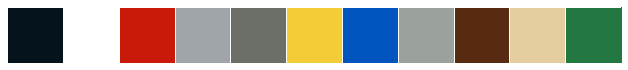

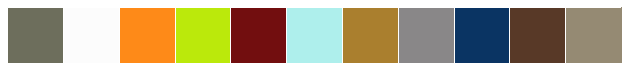

In [4]:
part_col = inv_parts.merge(colors, how="left", left_on="color_id", right_on="id")
lego_palette = pd.Series(part_col["rgb"].value_counts().index.values).map(lambda x: "#" + x)
lego_palette2 = lego_palette[11:]

sns.palplot(sns.color_palette(lego_palette[:11]))
sns.palplot(sns.color_palette(lego_palette2[:11]))

### Make a plot of unique sets per year

In [5]:
# Group by years and count unique set numbers
sets_unique = sets[sets["year"]<2017]
sets_unique = sets_unique.groupby(["year"])["set_num"].apply(lambda x: len(x.unique()))

In [6]:
print "Total Sets: " + str(len(sets["set_num"].value_counts().index))

Total Sets: 11542


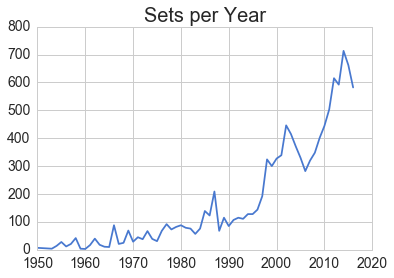

In [7]:
# plot
sns.set_style("whitegrid")
sns.set_palette("muted")

plt.plot(sets_unique)
plt.tick_params(labelsize=14)
plt.title("Sets per Year",fontsize=20)

plt.savefig("sets_year.png")
plt.show()

### Complete joins for a consolidated dataframe

In [8]:
parts_df = inv_parts.merge(inv,"left",left_on="inventory_id",right_on="id")
parts_df.head()

,inventory_id,part_num,color_id,quantity,is_spare,id,version,set_num
0,1,48379c01,72,1,f,1,1,7922-1
1,1,48395,7,1,f,1,1,7922-1
2,1,mcsport6,25,1,f,1,1,7922-1
3,1,paddle,0,1,f,1,1,7922-1
4,3,11816pr0005,78,1,f,3,1,3931-1


In [9]:
# Check for nulls in right-side dataframe
print parts_df["id"].isnull().sum()
print parts_df["version"].isnull().sum()
print parts_df["set_num"].isnull().sum()

0
0
0


In [10]:
# Check to see if inventory ID and set_num are 1-to-1
print len(parts_df["inventory_id"].value_counts().index)
print len(parts_df["id"].value_counts().index)
print len(parts_df["set_num"].value_counts().index)

10590
10590
10587


In [11]:
# Merge to sets to get the year
parts_yr_df = parts_df.merge(sets,"left",left_on="set_num",right_on="set_num")
parts_yr_df.head()

,inventory_id,part_num,color_id,quantity,is_spare,id,version,set_num,name,year,theme_id,num_parts
0,1,48379c01,72,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4
1,1,48395,7,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4
2,1,mcsport6,25,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4
3,1,paddle,0,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4
4,3,11816pr0005,78,1,f,3,1,3931-1,Emma's Splash Pool,2012,494,43


In [12]:
# Check for nulls in right-side dataframe
print parts_yr_df["name"].isnull().sum()
print parts_yr_df["year"].isnull().sum()
print parts_yr_df["theme_id"].isnull().sum()
print parts_yr_df["num_parts"].isnull().sum()

0
0
0
0


In [13]:
# Remove 2017 data
parts_yr_df = parts_yr_df[parts_yr_df["year"]<2017]

In [14]:
# Test the 1953 rows to see how many "unique" parts there should be
print parts_yr_df[parts_yr_df["year"]==1953].shape

(18, 12)


### Investigate history of new pieces

In [15]:
# make another column to track unique parts/color combos
parts_yr_df["part_color_id"] = parts_yr_df["part_num"] + parts_yr_df["color_id"].map(str)

In [16]:
# group by parts and colors
parts_col_counts = parts_yr_df.groupby(["year"])["part_color_id"].count()

print "Total Parts/col: " + str(len(parts_yr_df["part_color_id"].value_counts().index))

Total Parts/col: 41692


In [17]:
# group just by parts
parts_counts = parts_yr_df.groupby(["year","part_num"],as_index=False)["version"].count().groupby(["year"])["part_num"].count()

print "Total Parts: " + str(len(parts_yr_df["part_num"].value_counts().index))

Total Parts: 21913


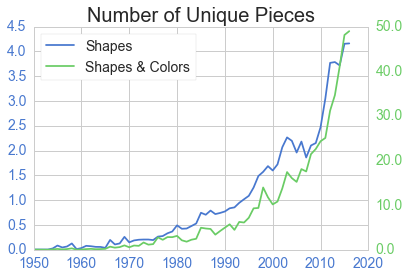

In [18]:
# plot
sns.set_style("whitegrid")
sns.set_palette("muted")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ln1 = ax1.plot(parts_counts, color=sns.color_palette()[0])
ln2 = ax2.plot(parts_col_counts, color=sns.color_palette()[1])

ax1.tick_params(labelsize=14, colors=sns.color_palette()[0])
ax2.tick_params(labelsize=14, colors=sns.color_palette()[1])

# added three lines
lns = ln1+ln2
labs = ["Shapes","Shapes & Colors"]
ax1.legend(lns, labs, loc=0, fontsize=14, frameon=True)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x*1e-3)

formatter = FuncFormatter(thousands)

ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

ax2.grid(None)

plt.title("Number of Unique Pieces", fontsize=20)
plt.savefig("unique_pieces.png")

plt.show()

### Investigate the changes in color

In [19]:
# Merge to get color names
parts_col_df = parts_yr_df.merge(colors,"left",left_on="color_id",right_on="id")
parts_col_df.head()

,inventory_id,part_num,color_id,quantity,is_spare,id_x,version,set_num,name_x,year,theme_id,num_parts,part_color_id,id_y,name_y,rgb,is_trans
0,1,48379c01,72,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4,48379c0172,72,Dark Bluish Gray,6C6E68,f
1,1,48395,7,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4,483957,7,Light Gray,9BA19D,f
2,1,mcsport6,25,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4,mcsport625,25,Orange,FE8A18,f
3,1,paddle,0,1,f,1,1,7922-1,McDonald's Sports Set Number 6 - Orange Vest S...,2004,460,4,paddle0,0,Black,05131D,f
4,3,11816pr0005,78,1,f,3,1,3931-1,Emma's Splash Pool,2012,494,43,11816pr000578,78,Light Flesh,F6D7B3,f


In [20]:
# Check for nulls in right-side dataframe
print parts_col_df["id_y"].isnull().sum()
print parts_col_df["name_y"].isnull().sum()
print parts_col_df["rgb"].isnull().sum()
print parts_col_df["is_trans"].isnull().sum()

0
0
0
0


In [21]:
# count unique colors per year
color_freq = parts_col_df.groupby(["year","id_y"],as_index=False)["is_trans"].count().groupby(["year"])["id_y"].count()
color_freq=pd.DataFrame(color_freq)
color_freq = color_freq.reset_index()

# subset to years 2000-2010, inclusive
color_freq = color_freq[color_freq["year"]>=2000]
color_freq = color_freq[color_freq["year"]<2011]

color_freq

,year,id_y
48,2000,53
49,2001,66
50,2002,71
51,2003,87
52,2004,91
53,2005,97
54,2006,85
55,2007,68
56,2008,60
57,2009,61


In [22]:
# Get most used color for each year by number of pieces using it
# Not used elsewhere

# group by color names
col_rgb = parts_col_df.groupby(["year","rgb"],as_index=False)["is_trans"].count()
col_rgb.columns = ["year","rgb","freq"]

# subset to years 2000-2010, inclusive
col_rgb = col_rgb[col_rgb["year"]>=2000]
col_rgb = col_rgb[col_rgb["year"]<2011]

# Get percents of color for each year
pcts = col_rgb.groupby(["year"])["freq"].apply(lambda x: 100.0*x/x.sum())
col_rgb["percents"] = pcts

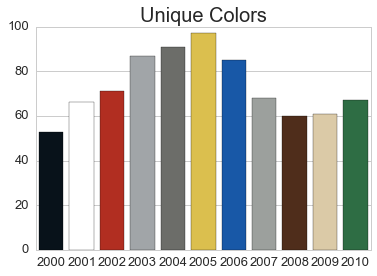

In [23]:
sns.set_style("whitegrid")
sns.set_palette(lego_palette)

fig, ax = plt.subplots()

sns.barplot(x="year", y="id_y", data=color_freq)
plt.title("Unique Colors",fontsize=20)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=13)

plt.savefig("unique_colors.png")
plt.show()

### Investigate pieces shared across sets

In [24]:
# Groupby to find sets per part per year
parts_df = parts_yr_df.groupby(["part_num","year"],as_index=False)["set_num"].apply(lambda x: len(x.unique()))
parts_df = pd.DataFrame(parts_df)
parts_df = parts_df.reset_index().ix[:,"part_num":"set_num"]

# Filter years
parts_df = parts_df[parts_df["year"]<2011]
parts_df = parts_df[parts_df["year"]>=2000]

In [25]:
# Pivot to see years as column headers
parts_pivot = parts_df.pivot(index="part_num", columns="year",values="set_num")

# Only show part numbers with at least 1 set in this timeframe
parts_pivot = parts_pivot.dropna(axis=0,how="all")

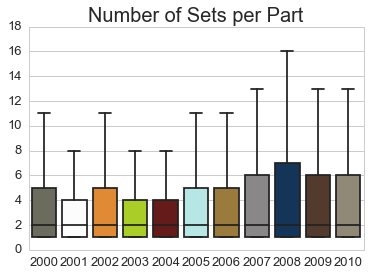

In [26]:
# plot
sns.set_style("whitegrid")
sns.set_palette(lego_palette2)

fig, ax = plt.subplots()

sns.boxplot(x="year",y="set_num", data=parts_df, showfliers=False)
plt.title("Number of Sets per Part", fontsize=20)

plt.ylim(0,18)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=13)

plt.savefig("sets_per_part.png")
plt.show()

### Clustering Parts

In [27]:
# Merge dataframes to get part dataframe
parts_agg = inv_parts.merge(parts,how="left",on="part_num")
parts_agg = parts_agg.merge(colors,how="left",left_on="color_id",right_on="id")

# Drop repeated or non-descriptive columns, null values for part_cat_id
parts_dropped = parts_agg.drop(["inventory_id","quantity","name_x","name_y","id","rgb"],axis=1)
parts_dropped = parts_dropped.dropna(axis=0,)

print parts_dropped.shape
parts_dropped = parts_dropped.drop_duplicates()
print parts_dropped.shape

(567674, 5)
(44753, 5)


In [28]:
# Check for NAN values
print sum(parts_dropped["part_num"].isnull())
print sum(parts_dropped["color_id"].isnull())
print sum(parts_dropped["is_spare"].isnull())
print sum(parts_dropped["part_cat_id"].isnull())
print sum(parts_dropped["is_trans"].isnull())

0
0
0
0
0


In [29]:
parts_updated = parts_dropped.copy()

# "Dummify" categorical columns
parts_updated["is_spare_num"] = 1
parts_updated["is_spare_num"][parts_updated["is_spare"]=="f"] = 0

parts_updated["is_trans_num"] = 1
parts_updated["is_trans_num"][parts_updated["is_trans"]=="f"] = 0

parts_updated["part_cat_id"] = parts_updated["part_cat_id"].map(lambda x: int(x)) 

parts_updated = parts_updated.drop(["is_spare","is_trans"],axis=1)

print parts_updated.shape
parts_updated.head()

(44753, 5)


C:\Users\Nicole\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Nicole\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,part_num,color_id,part_cat_id,is_spare_num,is_trans_num
0,48379c01,72,27,0,0
1,48395,7,27,0,0
2,mcsport6,25,13,0,0
3,paddle,0,27,0,0
4,11816pr0005,78,13,0,0


In [30]:
print sum(parts_updated["part_num"].isnull())
print sum(parts_updated["color_id"].isnull())
print sum(parts_updated["part_cat_id"].isnull())
print sum(parts_updated["is_spare_num"].isnull())
print sum(parts_updated["is_trans_num"].isnull())

0
0
0
0
0


In [31]:
idx = random.sample(parts_updated.index.values, 5000)
X = parts_updated.ix[idx,"color_id":"is_trans_num"]
X = X.reset_index().drop("index",axis=1)
X.head()

,color_id,part_cat_id,is_spare_num,is_trans_num
0,4,13,0,0
1,182,15,0,1
2,272,14,0,0
3,15,27,0,0
4,27,51,0,0


In [32]:
# Code from:
#http://datascience.stackexchange.com/questions/6508/k-means-incoherent-behaviour-choosing-k-with-elbow-method-bic-variance-explain
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

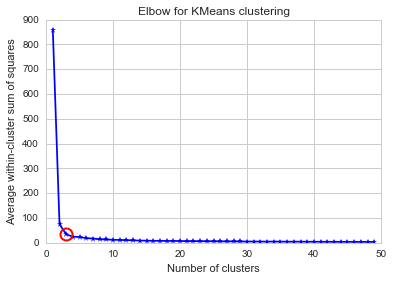

In [33]:
kIdx = 3-1

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [34]:
clusters = KM[2].predict(parts_updated.ix[:,"color_id":"is_trans_num"])
cl_centroids = pd.DataFrame(centroids[2],columns=X.columns.values).applymap(lambda x: round(x,3))
cl_centroids

,color_id,part_cat_id,is_spare_num,is_trans_num
0,28.198,21.600,0.048,0.079
1,9999.000,16.907,0.500,0.000
2,300.312,21.943,0.042,0.026


2                               Bricks Sloped
3                     Duplo, Quatro and Primo
12                                   Minifigs
26                        Minifig Accessories
40    Bionicle, Hero Factory and Constraction
Name: name, dtype: object


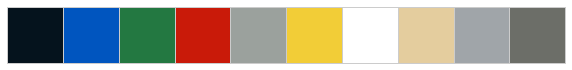

In [35]:
# Investigate cluster 0

# Top 10 most common colors in cluster
cl0_idx = parts_updated[clusters == 0]["color_id"].value_counts()[:10].index.values
rgb_0 = colors[colors["id"].isin(cl0_idx)]["rgb"].map(lambda x: "#" + x)
sns.palplot(sns.color_palette(rgb_0))
plt.savefig("cluster0_palette.png",transparent=True)

# Top 10 most common part categories
cl0_idx_parts = parts_updated[clusters == 0]["part_cat_id"].value_counts()[:5].index.values
print part_cat[part_cat["id"].isin(cl0_idx_parts)]["name"]

3              Duplo, Quatro and Primo
12                            Minifigs
16                            Non-LEGO
37    Flags, Signs, Plastics and Cloth
41        Belville, Scala and Fabuland
Name: name, dtype: object


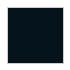

In [36]:
# Investigate cluster 1

# Top 10 most common colors in cluster
cl1_idx = parts_updated[clusters == 1]["color_id"].value_counts()[:10].index.values
rgb_1 = colors[colors["id"].isin(cl1_idx)]["rgb"].map(lambda x: "#" + x)
sns.palplot(sns.color_palette(rgb_1))
plt.savefig("cluster1_palette.png",transparent=True)

# Top 10 most common part categories
cl1_idx_parts = parts_updated[clusters == 1]["part_cat_id"].value_counts()[:5].index.values
print part_cat[part_cat["id"].isin(cl1_idx_parts)]["name"]

2                               Bricks Sloped
12                                   Minifigs
26                        Minifig Accessories
27                         Plants and Animals
40    Bionicle, Hero Factory and Constraction
Name: name, dtype: object


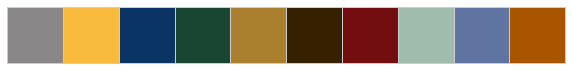

In [37]:
# Investigate cluster 2

# Top 10 most common colors in cluster
cl2_idx = parts_updated[clusters == 2]["color_id"].value_counts()[:10].index.values
rgb_2 = colors[colors["id"].isin(cl2_idx)]["rgb"].map(lambda x: "#" + x)
sns.palplot(sns.color_palette(rgb_2))
plt.savefig("cluster2_palette.png",transparent=True)

# Top 10 most common part categories
cl2_idx_parts = parts_updated[clusters == 2]["part_cat_id"].value_counts()[:5].index.values
print part_cat[part_cat["id"].isin(cl2_idx_parts)]["name"]

### Cluster Themes

In [38]:
# Total number of themes
len(themes["name"].value_counts().index)

399

In [39]:
sets_merge = sets.merge(themes, how="left", left_on="theme_id", right_on="id")
sets_merge.head()

,set_num,name_x,year,theme_id,num_parts,id,name_y,parent_id
0,00-1,Weetabix Castle,1970,414,471,414,Castle,411.0
1,0011-2,Town Mini-Figures,1978,84,12,84,Supplemental,67.0
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,199,Lion Knights,186.0
3,0012-1,Space Mini-Figures,1979,143,12,143,Supplemental,126.0
4,0013-1,Space Mini-Figures,1979,143,12,143,Supplemental,126.0


In [40]:
# Get number of sets per theme each year
sets_merge_unique = sets_merge.groupby(["year","name_y"])["name_x"].apply(lambda x: len(x.unique()))
#sets_merge_unique.to_csv("set_themes.csv")

sets_merge_unique = sets_merge_unique.unstack()